# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from scipy.signal import find_peaks as fp
import scipy.stats as st
import itertools
import warnings
from statsmodels.tsa.statespace.varmax import VARMAX
warnings.filterwarnings("ignore")

# Read the data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/eserinanarslan/ge_sales_prediction/master/sales_dataset.csv",
                 index_col="Month", parse_dates=True)
data.sort_index(inplace=True)
dfsx = data.copy()
dfs = data.copy()
exog = []
for i in range(1, 4):
    while len(exog) < 105:
        exog.append(random.randrange(1000, 5000))
    dfsx["x"+str(i)] = exog
    exog = []
df_varmax = dfsx.copy()
df_varmax["demand"] = np.sin(df_varmax["Sales"])*10000+10000
df_varmax = df_varmax[[df_varmax.columns[0], df_varmax.columns[-1],"x1", "x2", "x3"]]

# Sarimax

In [3]:
pd.concat([dfsx.head(), dfsx.tail()], axis=0)

,Sales,x1,x2,x3
Month,,,,
1984-01-01,2815,2166,2251,4740
1984-02-01,2672,2932,3506,2448
1984-03-01,2755,2590,3338,2559
1984-04-01,2721,3813,2002,3263
1984-05-01,2946,4115,4414,4158
1992-05-01,4618,3969,3589,2079
1992-06-01,5312,1853,4641,2312
1992-07-01,4298,4424,1398,2576
1992-08-01,1413,4135,2966,1553


# First view

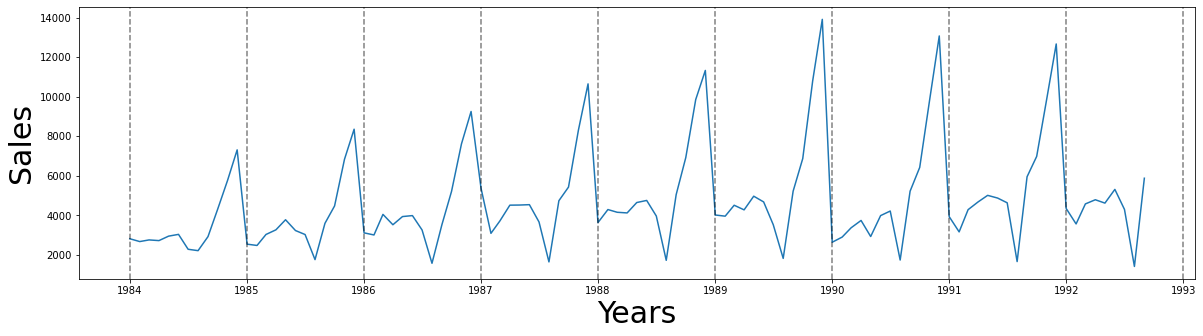

In [4]:
plt.figure(figsize=(20,5))
plt.plot(data["Sales"])
for year in range(dfsx.index.year.min(), dfsx.index.year.max()+2):
    plt.axvline(datetime(year,1,1), linestyle="--", color="black", alpha=0.5)
plt.xlabel("Years", fontsize=30)
plt.ylabel("Sales", fontsize=30)
plt.show()

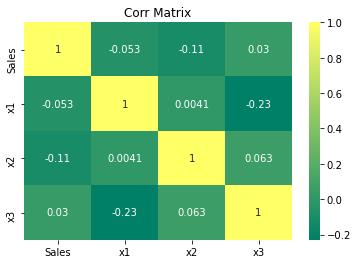

In [5]:
sns.heatmap(dfsx.corr(), annot=True, cmap="summer").set_title("Corr Matrix");

# Data Transformation

## Fixing variables into range between 1 - 2 because the variables have different range and scales.

In [6]:
#sc_in = MinMaxScaler(feature_range=(1,2))
sc_in = MinMaxScaler()
scaled_input = sc_in.fit_transform(dfsx[["x1", "x2", "x3"]])
scaled_input = pd.DataFrame(scaled_input, columns=["x1", "x2", "x3"])
X = scaled_input
X.index = dfsx.index
X.head()

,x1,x2,x3
Month,,,
1984-01-01,0.292095,0.310528,0.936777
1984-02-01,0.484316,0.627367,0.347726
1984-03-01,0.398494,0.584953,0.376253
1984-04-01,0.705395,0.247665,0.557183
1984-05-01,0.781179,0.856602,0.787201


In [7]:
#sc_out = MinMaxScaler(feature_range=(1,2))
sc_out = MinMaxScaler()
scaled_output = sc_out.fit_transform(dfsx[["Sales"]])
scaled_output = pd.DataFrame(scaled_output, columns=["sales"])
y = scaled_output
y.index = dfsx.index
pd.concat([y.head(), y.tail()], axis=0)

,sales
Month,
1984-01-01,0.112133
1984-02-01,0.100696
1984-03-01,0.107334
1984-04-01,0.104615
1984-05-01,0.122611
1992-05-01,0.256338
1992-06-01,0.311845
1992-07-01,0.230745
1992-08-01,0.000000


# Split Train - Test

In [8]:
train_size = -9
SX_train, SX_test, Sy_train, Sy_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

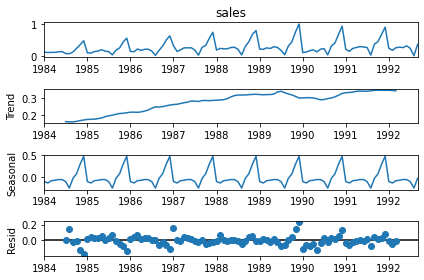

In [9]:
seas_d = sm.tsa.seasonal_decompose(y["sales"], model="add")
seas_d.plot()
plt.show()

# Some functions to measure the accuracy of the forecast

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

def wmape(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.abs(y_true))) * 100

## AD Fuller Test For Stationarity

In [11]:
y_stationarity = y["sales"][:train_size]

In [12]:
def adfuller_test_results(data):
    results = adfuller(data)
    print("ADF Statistics: %f" % results[0])
    print("p-value: %f" % results[1])
    print("Critical Values:")
    for key, value in results[4].items():
        print("\t%s: %.3f" % (key, value))
    if results[1] < 0.05:
        print("There is stationary. The data might be OK. You should also check the variance.")
    else:
        print("There is no stationary. You have to transform your data.")

In [13]:
adfuller_test_results(y_stationarity)

ADF Statistics: -1.620557
p-value: 0.472437
Critical Values:
	1%: -3.511
	5%: -2.897
	10%: -2.585
There is no stationary. You have to transform your data.


In [14]:
adfuller_test_results(y_stationarity.diff().dropna())

ADF Statistics: -24.789744
p-value: 0.000000
Critical Values:
	1%: -3.511
	5%: -2.897
	10%: -2.585
There is stationary. The data might be OK. You should also check the variance.


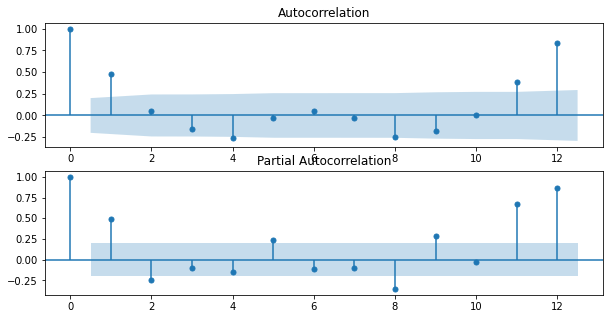

In [15]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_stationarity, lags=12, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_stationarity, lags=12, ax=ax[1])
plt.show()

In [16]:
SX_train = sm.add_constant(SX_train)
SX_test = sm.add_constant(SX_test)

---

# Prediction Using SARIMAX with AUTO ARIMA

In [17]:
arima_model = auto_arima(y=Sy_train, X=SX_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-190.772, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-181.467, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-201.890, Time=0.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-212.622, Time=1.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-209.202, Time=0.47 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-211.928, Time=1.82 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-211.371, Time=2.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-213.431, Time=1.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-211.739, Time=2.48 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-210.057, Time=3.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-195.759, Time=0.46 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-218.420, Time=1.66 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-211.461, Time=0.70 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-217.512, Time=2.74 sec
 ARIMA(1,1,1)(1,1,1

In [18]:
tuned_sarimax_model = sm.tsa.statespace.SARIMAX(Sy_train,
                                         order=arima_model.order,
                                         seasonal_order=arima_model.seasonal_order,
                                         exog=SX_train,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
decomposition = tuned_sarimax_model.fit()
print(decomposition.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                  96.661
Date:                             Wed, 10 Mar 2021   AIC                           -177.322
Time:                                     10:51:59   BIC                           -159.334
Sample:                                 01-01-1984   HQIC                          -170.177
                                      - 12-01-1991                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.205e-09   1.44e-10    -15.367      0.000   -2.49e-09   -1.92e-09
x1             0.0137      

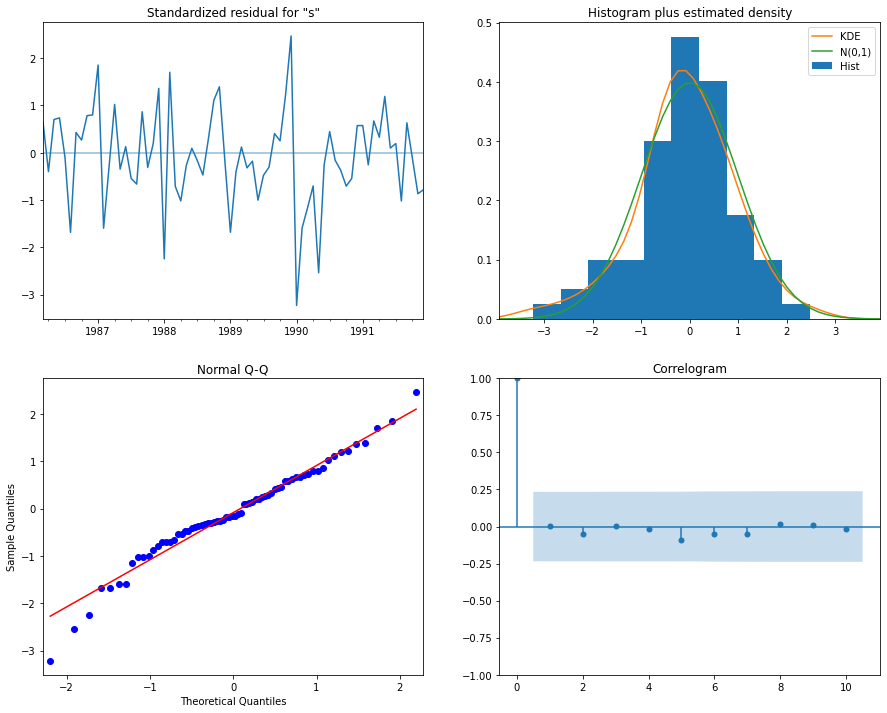

In [19]:
decomposition.plot_diagnostics(figsize=(15,12))
plt.show()

In [20]:
pred_uc = decomposition.get_forecast(steps=9, exog=SX_test)
pred_ci = pred_uc.conf_int()

In [21]:
predicted = decomposition.forecast(9, exog=SX_test)
y_pred = sc_out.inverse_transform(pd.DataFrame(predicted))
y_pred = pd.DataFrame(y_pred, index=predicted.index, columns=["y_pred"])
y_pred

,y_pred
1992-01-01,3231.876990
1992-02-01,3070.737598
1992-03-01,4299.853659
1992-04-01,4269.114482
1992-05-01,4176.460936
1992-06-01,4368.783913
1992-07-01,4642.617501
1992-08-01,1689.885479
1992-09-01,5769.342736


In [22]:
lower_bound = sc_out.inverse_transform(pd.DataFrame(pred_ci.iloc[:,0]))
lower_bound = pd.DataFrame(lower_bound, index=pred_ci.index, columns=["lower_bound"])
lower_bound

upper_bound = sc_out.inverse_transform(pd.DataFrame(pred_ci.iloc[:,1]))
upper_bound = pd.DataFrame(upper_bound, index=pred_ci.index, columns=["upper_bound"])
upper_bound

pred_ci_unscaled = pd.concat([lower_bound, upper_bound], axis=1)

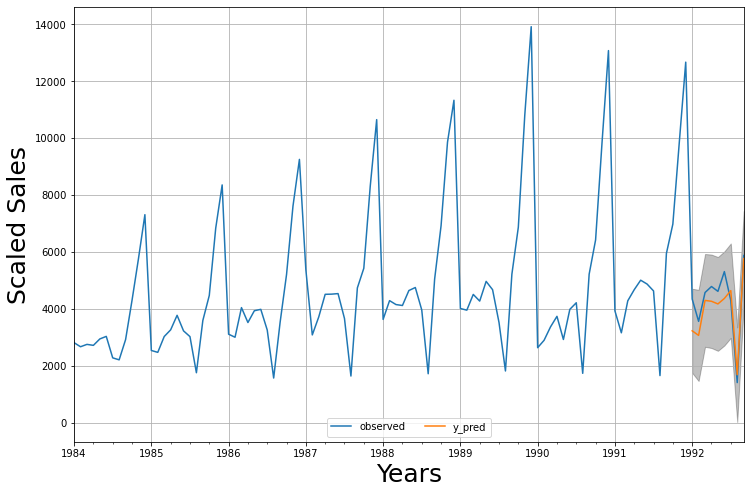

In [23]:
ax = data["Sales"].plot(figsize=(12,8), label="observed")
y_pred.plot(ax=ax, label="forecast")
ax.fill_between(pred_ci_unscaled.index,
               pred_ci_unscaled.iloc[:,0],
               pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Scaled Sales", size=25)
plt.legend(loc="lower center", ncol=2)
plt.grid()
plt.show()

### MAPE

In [24]:
print("MAPE:",mean_absolute_percentage_error(pd.Series(data["Sales"][y_pred.index[0]:]), pd.Series(y_pred["y_pred"])))
print("WMAPE:",wmape(pd.Series(data["Sales"][y_pred.index[0]:]), pd.Series(y_pred["y_pred"])))
print("RMSE:",np.sqrt(mean_squared_error(pd.Series(data["Sales"][y_pred.index[0]:]), pd.Series(y_pred["y_pred"]))))

MAPE: 12.573937313098089
WMAPE: 12.573937313098089
RMSE: 589.417872467192


---

# Let's predict even furter with a fictisious data

In [25]:
from dateutil.relativedelta import relativedelta
test_exog = SX_test.copy()
liste = list()
for idx in range(len(SX_test.index)):
    new_idx = test_exog.index[idx] + relativedelta(months=9)
    liste.append(new_idx)
test_exog.index = liste
test_exog = test_exog * 5**2.123 / 21.213
test_exog["const"] = 1
test_exog = pd.concat([SX_test, test_exog], axis=0)

In [26]:
pd.concat([test_exog.head(), test_exog.tail()])

,const,x1,x2,x3
1992-01-01,1.0,0.106650,0.744509,0.826009
1992-02-01,1.0,0.218821,0.949760,0.902596
1992-03-01,1.0,0.551568,0.269376,0.199178
1992-04-01,1.0,0.804015,0.655895,0.557183
1992-05-01,1.0,0.744542,0.648321,0.252891
1993-02-01,1.0,1.069548,0.931325,0.363283
1993-03-01,1.0,0.306770,1.312850,0.449304
1993-04-01,1.0,1.233567,0.136725,0.546770
1993-05-01,1.0,1.129388,0.705385,0.169089
1993-06-01,1.0,0.165100,0.058026,0.411647


In [27]:
get_fict_prediction = decomposition.get_prediction(start=test_exog.index[0], end=test_exog.index[-1], exog=test_exog)
fictisious_pred = get_fict_prediction.predicted_mean
fict_pred_ci = get_fict_prediction.conf_int()

In [28]:
fict_y_pred = sc_out.inverse_transform(pd.DataFrame(fictisious_pred))
fict_y_pred = pd.DataFrame(fict_y_pred, index=fictisious_pred.index, columns=["fict_y_pred"])
fict_y_pred

,fict_y_pred
1992-01-01,3231.876990
1992-02-01,3070.737598
1992-03-01,4299.853659
1992-04-01,4269.114482
1992-05-01,4176.460936
1992-06-01,4368.783913
1992-07-01,4642.617501
1992-08-01,1689.885479
1992-09-01,5769.342736
1992-10-01,6587.070353


In [29]:
fict_lower_bound = sc_out.inverse_transform(pd.DataFrame(fict_pred_ci.iloc[:,0]))
fict_lower_bound = pd.DataFrame(fict_lower_bound, index=fict_pred_ci.index, columns=["lower_bound"])
fict_lower_bound

fict_upper_bound = sc_out.inverse_transform(pd.DataFrame(fict_pred_ci.iloc[:,1]))
fict_upper_bound = pd.DataFrame(fict_upper_bound, index=fict_pred_ci.index, columns=["upper_bound"])
fict_upper_bound

fict_pred_ci_unscaled = pd.concat([fict_lower_bound, fict_upper_bound], axis=1)

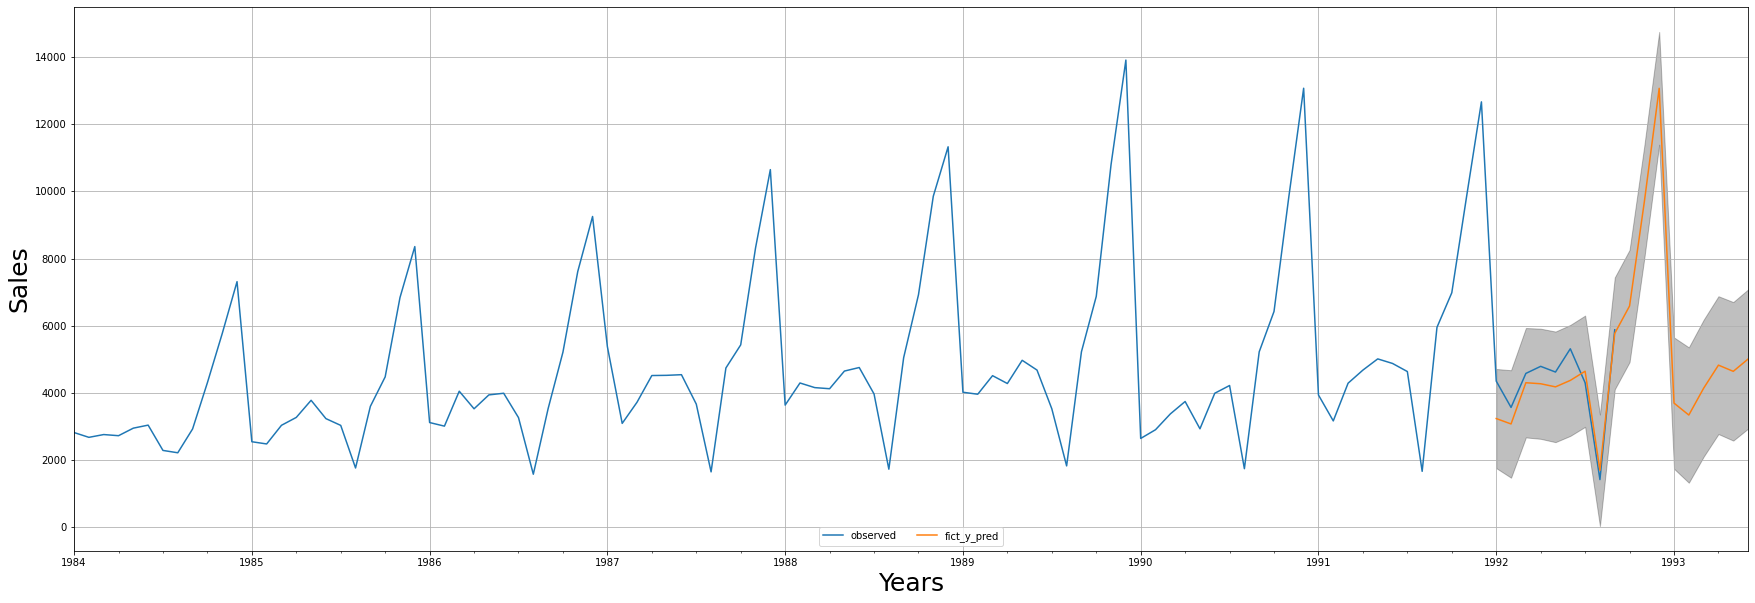

In [30]:
ax = data["Sales"].plot(figsize=(30,10), label="observed")
fict_y_pred.plot(ax=ax, label="forecast")
ax.fill_between(fict_pred_ci_unscaled.index,
               fict_pred_ci_unscaled.iloc[:,0],
               fict_pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Sales", size=25)
plt.legend(loc="lower center", ncol=2)
plt.grid()
plt.show()

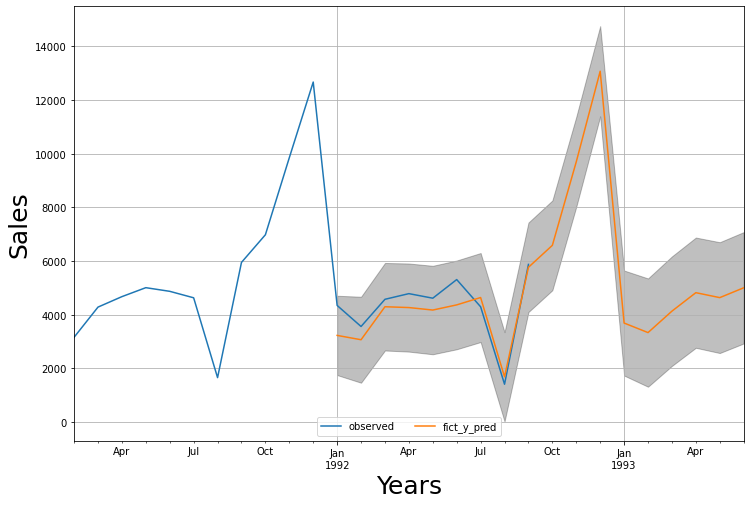

In [31]:
ax = data["Sales"][-20:].plot(figsize=(12,8), label="observed")
fict_y_pred.plot(ax=ax, label="forecast")
ax.fill_between(fict_pred_ci_unscaled.index,
               fict_pred_ci_unscaled.iloc[:,0],
               fict_pred_ci_unscaled.iloc[:,1], color="k", alpha=0.25)
ax.set_xlabel("Years", size=25)
ax.set_ylabel("Sales", size=25)
plt.legend(loc="lower center", ncol=2)
plt.grid()
plt.show()

---

# Prediction Using SARIMA with AUTO ARIMA

In [32]:
dfs_train, dfs_test = dfs[:-9], dfs[-9:]

correlation for lag 0: 100.0
correlation for lag 1: 50.68
correlation for lag 2: 5.42
correlation for lag 3: -17.22
correlation for lag 4: -27.58
correlation for lag 5: -2.56
correlation for lag 6: 6.03
correlation for lag 7: -2.4899999999999998
correlation for lag 8: -27.98
correlation for lag 9: -19.53
correlation for lag 10: 1.02
correlation for lag 11: 44.51
correlation for lag 12: 95.67999999999999


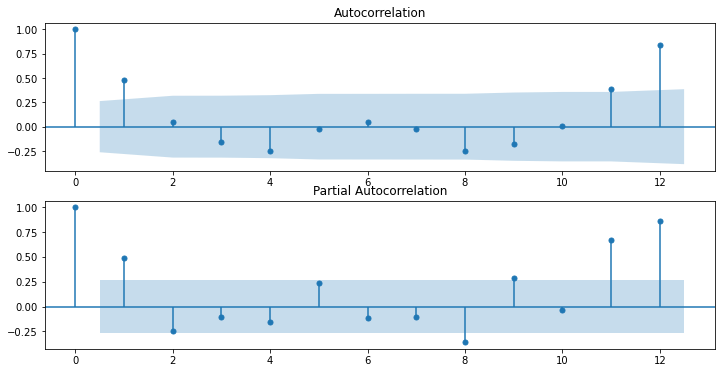

In [33]:
for i in range(0, 13):
    temp_df = pd.concat([dfs_train, dfs_train.shift(i)], axis=1)
    temp_df.columns = ["sales (t)", "sales(t-{})".format(i)]
    print("correlation for lag {}: ".format(i)+str(round(temp_df.corr().values[0][1], 4)*100))
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(dfs_train, lags=12, alpha=0.01, ax=ax[0])
ax[1] = plot_pacf(dfs_train, lags=12, alpha=0.01, ax=ax[1])
plt.show()

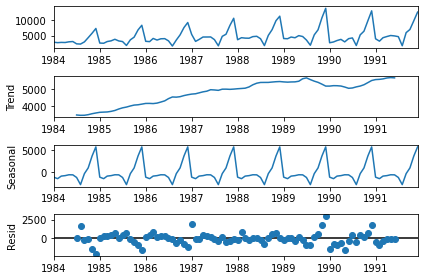

In [34]:
ts_decomp = sm.tsa.seasonal_decompose(dfs_train, model="additive")
ts_decomp.plot()
plt.show()

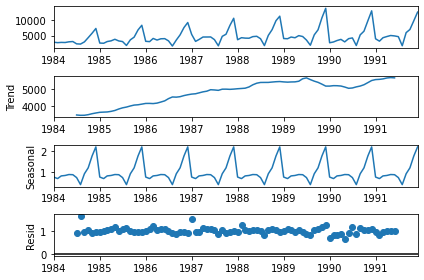

In [35]:
ts_decomp = sm.tsa.seasonal_decompose(dfs_train, model="multiplicative")
ts_decomp.plot()
plt.show()

In [36]:
sarima_model = auto_arima(y=dfs_train,
                        start_p=0, start_q=0,
                        max_p=13, max_q=13,m=12,
                        start_P=0, seasonal=True,
                        d=1, D=1, trace=True,
                        error_action="ignore",
                        suppress_warnings=True,
                        stepwise=True,
                        njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1375.769, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1381.924, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1365.629, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1353.063, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1353.768, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1353.783, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1353.799, Time=0.81 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1352.455, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1353.626, Time=0.63 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1373.221, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1347.461, Time=0.48 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1350.905, Time=0.20 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1348.258, Time=1.14 sec
 ARIMA(1,1,1)(1,1,1)[12]

In [37]:
tuned_sarima_model = sm.tsa.statespace.SARIMAX(dfs_train,
                                         order=sarima_model.order,
                                         seasonal_order=sarima_model.seasonal_order,
                                         enforce_invertibility=False,
                                         enforce_stationarity=False)
tuned_sarima_model_aic = tuned_sarima_model.fit()
print(tuned_sarima_model_aic.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -566.538
Date:                             Wed, 10 Mar 2021   AIC                           1141.075
Time:                                     10:52:21   BIC                           1150.069
Sample:                                 01-01-1984   HQIC                          1144.648
                                      - 12-01-1991                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3052      0.113      2.705      0.007       0.084       0.526
ma.L1         -0.9323      

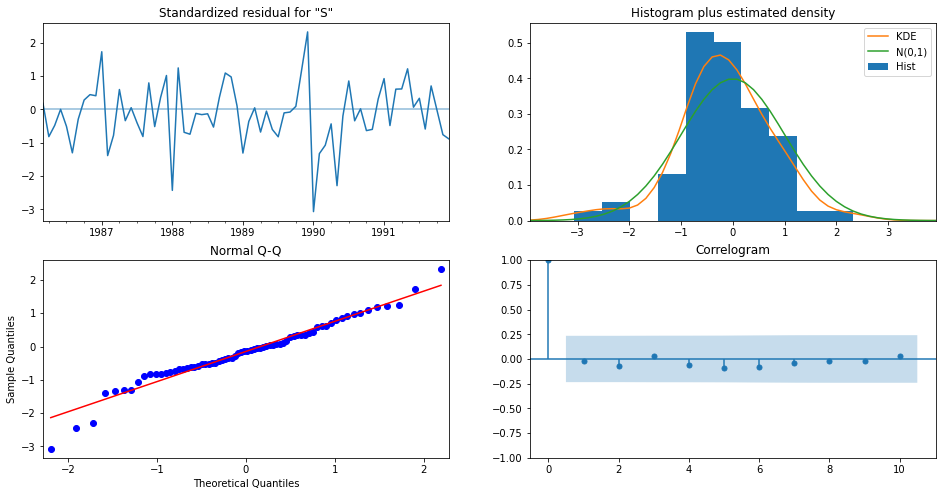

In [38]:
tuned_sarima_model_aic.plot_diagnostics(figsize=(16,8))
plt.show()

In [39]:
pred_forecast_sarima = tuned_sarima_model_aic.get_prediction(start=pd.to_datetime(dfs_test.index[0]), 
                                                        end=dfs_test.index[-1], 
                                                        dynamic=False)
pred_sarima = pred_forecast_sarima.predicted_mean

actual = pd.Series(dfs_test["Sales"][dfs_test.index[0]:])
print("MAPE:",mean_absolute_percentage_error(actual, pred_sarima))
print("RMSE:", np.sqrt(mean_squared_error(actual, pred_sarima)))

MAPE: 11.624795398967509
RMSE: 486.395042453163


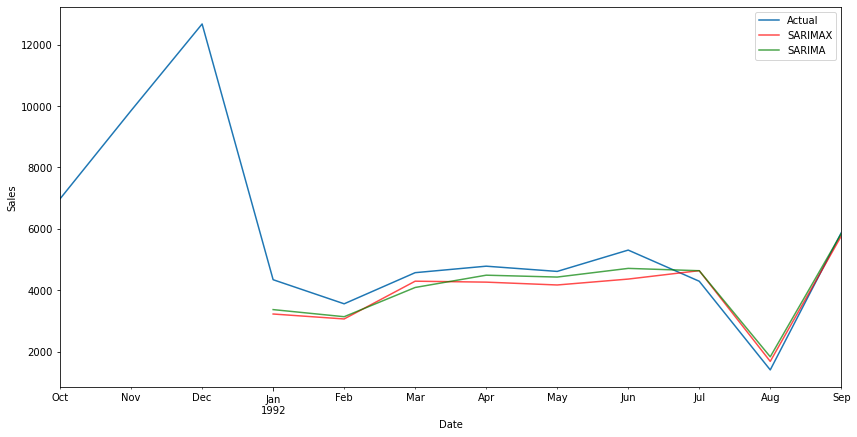

In [40]:
forecast_sarima = tuned_sarima_model_aic.get_forecast(steps=9)
predictions_sarima = forecast_sarima.predicted_mean
ci = forecast_sarima.conf_int()

fig = data[-12:].plot(label="observed", figsize=(14, 7))
fig.set_xlabel("Date")
fig.set_ylabel("Sales")
#fig.fill_between(ci.index,
#                ci.iloc[:, 0],
#                ci.iloc[:, 1], color = "k", alpha=0.2)

y_pred.plot(ax=fig, alpha=0.7, figsize=(14,7), color="r")
predictions_sarima.plot(ax=fig, alpha=0.7, figsize=(14,7), color="g")
plt.legend(labels=["Actual", "SARIMAX", "SARIMA"])
plt.show()

In [41]:
compare = data[-9:]
compare = pd.concat([compare, y_pred, predictions_sarima], axis=1).rename(columns={"Sales": "Actual",
                                                                                   "y_pred": "SARIMAX_pred",
                                                                                  "predicted_mean": "SARIMA_pred"})
compare

,Actual,SARIMAX_pred,SARIMA_pred
1992-01-01,4348,3231.876990,3375.197169
1992-02-01,3564,3070.737598,3143.866382
1992-03-01,4577,4299.853659,4095.227585
1992-04-01,4788,4269.114482,4495.083182
1992-05-01,4618,4176.460936,4434.113136
1992-06-01,5312,4368.783913,4716.532715
1992-07-01,4298,4642.617501,4640.658949
1992-08-01,1413,1689.885479,1839.475726
1992-09-01,5877,5769.342736,5849.317109


---

# VARMAX

In [42]:
df_varmax_train, df_varmax_test = df_varmax[:-9],  df_varmax[-9:]

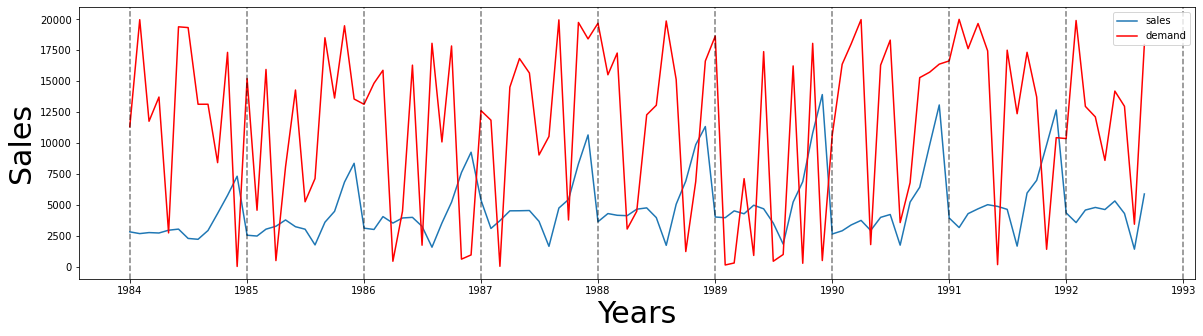

In [43]:
plt.figure(figsize=(20,5))
plt.plot(df_varmax["Sales"], label="sales")
plt.plot(df_varmax["demand"], color="r", label="demand")
for year in range(df_varmax.index.year.min(), df_varmax.index.year.max()+2):
    plt.axvline(datetime(year,1,1), linestyle="--", color="black", alpha=0.5)
plt.xlabel("Years", fontsize=30)
plt.ylabel("Sales", fontsize=30)
plt.legend(loc="upper right")
plt.show()

In [44]:
p = q = range(1,5)
pq = list(itertools.product(p, q))

metric_aic = dict()
for pq_metric in pq:
    varmax_model = VARMAX(endog=df_varmax_train[df_varmax_train.columns[:2].to_list()],
                          exog=df_varmax_train[df_varmax_train.columns[2:].to_list()],
                          order=pq_metric,
                          enforce_invertibility=False,
                          enforce_stationarity=False)
    varmax_model_fit = varmax_model.fit()
    metric_aic.update({pq_metric:varmax_model_fit.aic})


metric_aic = sorted(metric_aic.items(), key=lambda x:x[1])


tuned_varmax_model = VARMAX(endog=df_varmax_train[df_varmax_train.columns[:2].to_list()],
                            exog=df_varmax_train[df_varmax_train.columns[2:].to_list()],
                            order=metric_aic[0][0],
                            enforce_invertibility=False,
                            enforce_stationarity=False)

In [45]:
tuned_varmax_model = tuned_varmax_model.fit()
forcast_varmax = tuned_varmax_model.get_forecast(steps=9, exog=df_varmax_test[df_varmax_test.columns[2:].to_list()])
yhat = forcast_varmax.predicted_mean
ci_varmax = forcast_varmax.conf_int()

In [46]:
yhat

,Sales,demand
1992-01-01,8300.528122,11352.428412
1992-02-01,5998.333382,11309.448695
1992-03-01,5655.662896,15089.531766
1992-04-01,4936.216639,10355.537762
1992-05-01,4522.718682,11688.736480
1992-06-01,4262.373424,12117.171858
1992-07-01,5134.613796,12785.430176
1992-08-01,4433.511560,12258.752889
1992-09-01,5317.320770,16497.046011


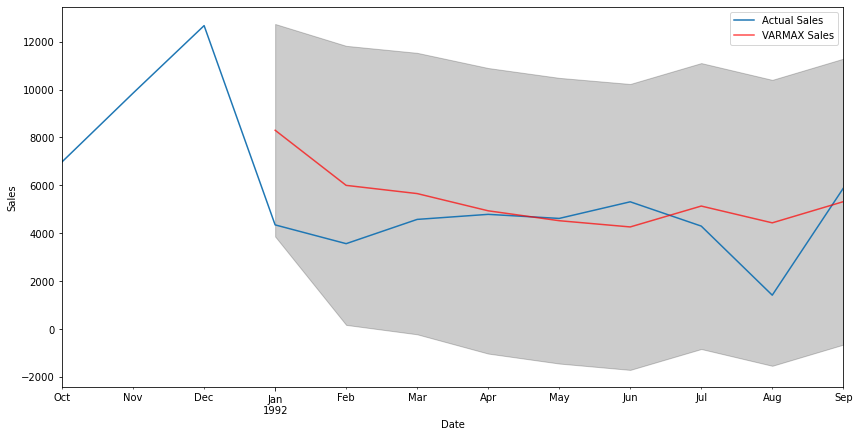

In [47]:
fig = df_varmax["Sales"][-12:].plot(label="observed", figsize=(14, 7))
fig.set_xlabel("Date")
fig.set_ylabel("Sales")
fig.fill_between(ci_varmax[[ci_varmax.columns[0], ci_varmax.columns[2]]].index,
                ci_varmax[[ci_varmax.columns[0], ci_varmax.columns[2]]].iloc[:, 0],
                ci_varmax[[ci_varmax.columns[0], ci_varmax.columns[2]]].iloc[:, 1], color = "k", alpha=0.2)

yhat["Sales"].plot(ax=fig, alpha=0.7, figsize=(14,7), color="r")
plt.legend(labels=["Actual Sales", "VARMAX Sales"])
plt.show()

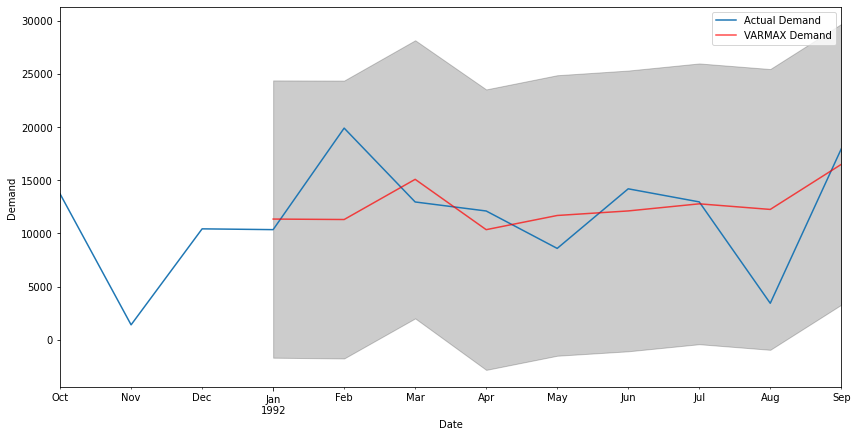

In [48]:
fig = df_varmax["demand"][-12:].plot(label="observed", figsize=(14, 7))
fig.set_xlabel("Date")
fig.set_ylabel("Demand")
fig.fill_between(ci_varmax[[ci_varmax.columns[1], ci_varmax.columns[-1]]].index,
                ci_varmax[[ci_varmax.columns[1], ci_varmax.columns[-1]]].iloc[:, 0],
                ci_varmax[[ci_varmax.columns[1], ci_varmax.columns[-1]]].iloc[:, 1], color = "k", alpha=0.2)

yhat["demand"].plot(ax=fig, alpha=0.7, figsize=(14,7), color="r")
plt.legend(labels=["Actual Demand", "VARMAX Demand"])
plt.show()

In [49]:
print("MAPE SARIMA:",mean_absolute_percentage_error(actual, pred_sarima))
print("RMSE SARIMA:", np.sqrt(mean_squared_error(actual, pred_sarima)))
print("*"*30, "\n")
print("MAPE SARIMAX:",mean_absolute_percentage_error(pd.Series(data["Sales"][y_pred.index[0]:]), pd.Series(y_pred["y_pred"])))
print("RMSE SARIMAX:",np.sqrt(mean_squared_error(pd.Series(data["Sales"][y_pred.index[0]:]), pd.Series(y_pred["y_pred"]))))
print("*"*30, "\n")
print("Sales MAPE VARMAX:",mean_absolute_percentage_error(df_varmax["Sales"][-9:], yhat["Sales"]))
print("Sales RMSE VARMAX:", np.sqrt(mean_squared_error(df_varmax["Sales"][-9:], yhat["Sales"])))
print("*"*30, "\n")
print("Demand MAPE VARMAX:",mean_absolute_percentage_error(df_varmax["demand"][-9:], yhat["demand"]))
print("Demand RMSE VARMAX:", np.sqrt(mean_squared_error(df_varmax["demand"][-9:], yhat["demand"])))

MAPE SARIMA: 11.624795398967509
RMSE SARIMA: 486.395042453163
****************************** 

MAPE SARIMAX: 12.573937313098089
RMSE SARIMAX: 589.417872467192
****************************** 

Sales MAPE VARMAX: 50.04973164027846
Sales RMSE VARMAX: 1943.1185537553297
****************************** 

Demand MAPE VARMAX: 44.58015291187729
Demand RMSE VARMAX: 4428.693412250969


---

# Peak Detection

In [50]:
def get_peaks(data, sigma=1.96):
    positions = []
    for i in range(0, len(data), 12):
        temp_df = data[i: i+12]
        avg, std = temp_df.mean(), temp_df.std()
        norm_df = (temp_df - avg) / std
        if len(norm_df[norm_df["Sales"] > sigma]) == 0:
            pass
        else:
            positions.append(norm_df[norm_df["Sales"] > sigma].index.values[0])
    print("The probablity:", round((1-(1-st.norm.cdf(sigma))*2)*100,2))
    return positions
positions = get_peaks(data=data, sigma=2.18)

dfs["peaks"] = [1 if i in positions else 0 for i in data.index]
dfsx["peaks"] = [1 if i in positions else 0 for i in data.index]
df_varmax["peaks"] = [1 if i in positions else 0 for i in data.index]

The probablity: 97.07


In [51]:
dfs["peaks"] = dfs["peaks"].astype("int8")
dfsx["peaks"] = dfsx["peaks"].astype("int8")
df_varmax["peaks"] = df_varmax["peaks"].astype("int8")

---

# TS to Supervised

In [52]:
def ts_to_supervised(data, lag_back=1, dropnan=True):
    """
    Converting data from time series to supervised.
        data: input data
        lag_back: number of times to backforward. Default is 1.
        dropnan: dropping nan observations. Default is True.
    Returns:
        supervised data
    """
    data = pd.DataFrame(data)
    new_df = []
    col_names = []
    for col in data.columns.to_list():
        for i in range(lag_back, -1, -1):
            new_df.append(data[col].shift(i))
            col_names.append("{} (t-{})".format(col, i))
    new_df = pd.concat(new_df, axis=1)
    new_df.columns = col_names
    if dropnan:
        new_df.dropna(inplace=True)
    return new_df

In [53]:
df_new = pd.merge(ts_to_supervised(data=dfs["Sales"], lag_back=9, dropnan=True), dfs["peaks"], how="left", left_index=True, right_index=True)

In [54]:
df_new

,Sales (t-9),Sales (t-8),Sales (t-7),Sales (t-6),Sales (t-5),Sales (t-4),Sales (t-3),Sales (t-2),Sales (t-1),Sales (t-0),peaks
Month,,,,,,,,,,,
1984-10-01,2815.0,2672.0,2755.0,2721.0,2946.0,3036.0,2282.0,2212.0,2922.0,4301,0
1984-11-01,2672.0,2755.0,2721.0,2946.0,3036.0,2282.0,2212.0,2922.0,4301.0,5764,0
1984-12-01,2755.0,2721.0,2946.0,3036.0,2282.0,2212.0,2922.0,4301.0,5764.0,7312,1
1985-01-01,2721.0,2946.0,3036.0,2282.0,2212.0,2922.0,4301.0,5764.0,7312.0,2541,0
1985-02-01,2946.0,3036.0,2282.0,2212.0,2922.0,4301.0,5764.0,7312.0,2541.0,2475,0
...,...,...,...,...,...,...,...,...,...,...,...
1992-05-01,1659.0,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0,4618,0
1992-06-01,5951.0,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0,4618.0,5312,0
1992-07-01,6981.0,9851.0,12670.0,4348.0,3564.0,4577.0,4788.0,4618.0,5312.0,4298,0


In [55]:
X = df_new.drop(columns="peaks")
y = df_new["peaks"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [57]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_model

GaussianNB()

In [58]:
nb_model.predict(X_test)
nb_model.predict_proba(X_test)[0:10]

array([[1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 4.08483722e-117],
       [8.47998950e-005, 9.99915200e-001],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 8.39911598e-322],
       [1.00000000e+000, 8.75792853e-174],
       [1.00000000e+000, 0.00000000e+000]])

In [59]:
y_pred = nb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9583333333333334


In [60]:
cross_val_score(nb_model, X_test, y_test, cv=10).mean()

0.9333333333333332

In [61]:
y_pred = pd.Series(y_pred, index=y_test.index)
pd.concat([pd.Series(y_pred), y_test], axis=1).head(15)

,0,peaks
Month,,
1987-02-01,0,0
1986-06-01,0,0
1986-12-01,1,1
1990-08-01,0,0
1991-02-01,0,0
1990-02-01,0,0
1987-03-01,0,0
1986-09-01,0,0
1990-06-01,0,0
